# Bayesian Neural Network with VI

In this notebook two simple bayesian neural networks will be trained using VI approach. Widely popular MNIST dataset will be used to train and evaluate.

## Theory


### Overview

The main point of BNN approaches is to treat parameters of the model $\theta$ as a random variable. By the use of Bayesian inference we get:
$$P(\theta|D) = \frac{P(D_y|D_x,\theta)P(\theta)}{\int_{\theta}P(D_y|D_x, \theta')P(\theta')d\theta'}.$$
We also use posterior predictive distribution (posteriate inference) to predict the new data:
$$P(y|x,D)=\int P(y|x,\theta')P(\theta'|D)d\theta'.$$
We approximate the integral by using Monte Carlo method:
$$\frac{1}{|\Theta|}\sum_{\theta_i\in\Theta}\Phi_{\theta_i}(x),$$
where $\Phi_{\theta_i}(x)$ is the output of our model with sampled parameters $\theta_i$.

The problem of such approach is that $P(\theta|D)$ is hard-to-evaluate distribution (one of the reasons is that $\int_{\theta}P(D_y|D_x, \theta')P(\theta')d\theta'$ in denominator could be untrackable). So we want somehow approximate such distribution. Two of the methods could be:

1) Markov Chain Monte Carlo (MCMC)
2) Variational Inference (VI)

In this notebook VI approach will be used.

### Variational Inference

The point of Variational Inference is to approximate complex function (in our case $P(\theta|D)$) by family of parameterized distributions $q_{\phi}(\theta)$. By default, I will use Gaussian distribution as mentioned $q_{\phi}=N(\mu_{\phi}, \sigma^2_{\phi})$.
The optimization problem appears from the task of minimizing the distance between $q_{\phi}$ and desired $P(\theta|D)$ in terms of minimizing the Kullback–Leibler divergence:
$$D_{KL}(q_{\phi}(\theta)||P(\theta|D))\longrightarrow min$$
As it can be shown, we can use Evidence Lower BOund to perform such minimization. The optimization task then rewrites as follows:
$$\mathbb{E}_{q_{\phi}}\log\left(\frac{\hat{P}(D|\theta)P(\theta)}{q_{\phi}(\theta)}\right)\longrightarrow max_{\phi},$$
Where $\hat{P}(D|\theta)$ is our neural net, $P(\theta)$ is ''prior over weights'' and $q_{\phi}(\theta)$ is defined parameterized distributition. In ''Pyro'' it is defined through the usage of ''Guide'' module.



## Code

### Libraries

Importing the libraries, that will be used through the whole notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange

import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torchvision import datasets
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
torch.manual_seed(3005)

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal

c:\Users\egork\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\egork\miniconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### Parameters setup

Here will be defined three priors, that can be used. 

In [2]:
dist_names = {"normal":dist.Normal(0,10),
              "laplace":dist.Laplace(0,10),
              "uniform":dist.Uniform(-10,10)}

We can choose between two models: MLP and Conv. It will define the input shape and model's arhitecture

In [3]:
model_name = "Conv" # could be MLP or Conv

### Bayesian Neural Network setup

Here two architectures will be setup. The PyTorch and Pyro libraries will be utilized together.

The first architecture is neural net with several Multi-Layer Perceptron (MLP) layers. As activation function we use ReLU. Also, batch normalization is used between layers.

In [4]:
class BNN_MLP_model(PyroModule):
    def __init__(self, in_dim=784, out_dim=10, hid_dim=200, layers_num = 1, distribution = "normal"):
        super().__init__()
        
        self.activation = nn.ReLU()  # activation function that will be used in net
        self.batch_in = nn.BatchNorm1d(hid_dim) # batch normalization
        self.batches = torch.nn.ModuleList([nn.BatchNorm1d(hid_dim) for i in range(layers_num - 1)]) # batch normalizations setup

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + layers_num * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        # Set weights using prior distribution
        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist_names[distribution].expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist_names[distribution].expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # layer -> batch normalization -> activation funtion
        x = self.activation(self.batch_in(self.layers[0](x)))  # initial layer
        for i, layer in enumerate(self.layers[1:-1]):
            x = self.activation(self.batches[i](layer(x)))  # hidden layers
        output = self.layers[-1](x).squeeze()  # final layer

        yhat = softmax(output, dim=1) # creating predictive distribution

        # send the signal to pyro.sample objects to update model parameters
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(yhat), obs=y)
        
        return yhat


The second architecture will use convolution layers.

In [5]:
class BNN_Conv_model(PyroModule):
    def __init__(self, in_dim=1, out_dim=10, layer_sizes = [16, 32, 64], kernel_sizes = [3, 3, 3], distribution = "normal"):
        super().__init__()
        
        self.pooling = nn.MaxPool2d(2) # pooling layer
        self.batch_in = nn.BatchNorm2d(layer_sizes[0]) # batch normalization
        self.batches = torch.nn.ModuleList([nn.BatchNorm2d(layer_sizes[i]) for i in range(1, len(layer_sizes))]) # batch normalizations setup

        # Define the layers and the PyroModule layer list
        self.layer_sizes = [in_dim] + layer_sizes + [out_dim]
        self.kernel_sizes = kernel_sizes
        layer_list = [PyroModule[nn.Conv2d](in_dim, layer_sizes[0], self.kernel_sizes[0], stride = 1, padding = 1)] + [PyroModule[nn.Conv2d](layer_sizes[i], layer_sizes[i+1], self.kernel_sizes[i+1], stride = 1, padding = 1) for i in range(len(layer_sizes) - 1)] + [PyroModule[nn.Linear](layer_sizes[-1], out_dim)]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        # Define transformations before final linear layer
        self.out_list = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

        # Set weights using prior distribution
        for layer_idx, layer in enumerate(self.layers):
            if layer_idx >= len(self.layers) - 1:
                layer.weight = PyroSample(dist_names[distribution].expand([self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
                layer.bias = PyroSample(dist_names[distribution].expand([self.layer_sizes[layer_idx + 1]]).to_event(1))
            else:
                layer.weight = PyroSample(dist_names[distribution].expand(
                    [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx],
                    self.kernel_sizes[layer_idx], self.kernel_sizes[layer_idx]]).to_event(4))
                layer.bias = PyroSample(dist_names[distribution].expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # layer -> batch normalization -> pooling
        x = self.pooling(self.batch_in(self.layers[0](x)))  # initial layer
        for i, layer in enumerate(self.layers[1:-1]):
            x = self.pooling(self.batches[i](layer(x)))  # hidden layers
        
        # average global pooling -> flatten -> linear layer
        mu = self.layers[-1]((self.out_list(x))).squeeze()

        yhat = softmax(mu, dim=1) # creating predictive distribution

        # send the signal to pyro.sample objects to update model parameters
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(yhat), obs=y)
        return yhat

### Data setup

Here we download and prepare MNIST dataset.

In [6]:
# download MNIST
mnist_train = datasets.MNIST('../data', train = True, download=True)
mnist_test = datasets.MNIST('../data', train= False, download=True)

# reshape MNIST
if model_name == "MLP":
    x_train = mnist_train.data.reshape(60000, 28*28).float()
    y_train = mnist_train.targets

    x_test = mnist_test.data.reshape(10000, 28*28).float()
    y_test = mnist_test.targets

elif model_name == "Conv":
    x_train = mnist_train.data.reshape(60000, 1, 28, 28).float()
    y_train = mnist_train.targets

    x_test = mnist_test.data.reshape(10000, 1, 28, 28).float()
    y_test = mnist_test.targets
    
print(x_train.shape)
print(x_test.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


### Model setup

Here we will define our models and algorithms for inference. ''num_particles'' parameter define the number of counted ELBO losses to choose from

In [7]:
epochs = 30

model = BNN_MLP_model(in_dim=32*32, out_dim=5749, hid_dim=300, layers_num=3)
print(model)

mean_field_guide = AutoNormal(model)
optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {"lr": 0.1}, 'gamma': 0.6})

svi = SVI(model, mean_field_guide, scheduler, loss=Trace_ELBO(num_particles=2))
pyro.clear_param_store()

BNN_MLP_model(
  (activation): ReLU()
  (batch_in): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batches): ModuleList(
    (0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layers): PyroModuleList(
    (0): PyroLinear(in_features=1024, out_features=300, bias=True)
    (1): PyroLinear(in_features=300, out_features=300, bias=True)
    (2): PyroLinear(in_features=300, out_features=300, bias=True)
    (3): PyroLinear(in_features=300, out_features=5749, bias=True)
  )
)


In [8]:
labels_num = 10 # 10 labels in MNIST

# Neural net model setup
if model_name == "MLP":
    in_dim_size = 28*28
    model = BNN_MLP_model(in_dim=in_dim_size, out_dim=labels_num, hid_dim=200, layers_num=1, distribution = "normal")
elif model_name == "Conv":
    in_dim_size = 1
    model = BNN_Conv_model(in_dim=in_dim_size, out_dim=labels_num, layer_sizes = [8, 16], kernel_sizes = [3, 3], distribution = "normal")

print(model) # printing model parameters

# VI net setup
epochs = 30 # Set the number of epochs
batch_size = 64 # Set the number of batches
mean_field_guide = AutoNormal(model) # We will set our guide to be automatically defined by Pyro
optimizer = torch.optim.Adam # Optimizer initialization
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {"lr": 0.1}, 'gamma': 0.6}) # Scheduler initialization

svi = SVI(model, mean_field_guide, scheduler, loss=Trace_ELBO(num_particles=2)) # Stochastic Variational inference initialization
pyro.clear_param_store()


BNN_Conv_model(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_in): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batches): ModuleList(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layers): PyroModuleList(
    (0): PyroConv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PyroConv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): PyroLinear(in_features=16, out_features=10, bias=True)
  )
  (out_list): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
  )
)


### Model training

Here we will train our model

In [9]:
prob_normal_train_loss = np.zeros(epochs*int(x_train.shape[0]/batch_size))
epoch_timer = 0
bar = trange(epochs)
for epoch in bar:
  for batch_idx in range(int(x_train.shape[0] / batch_size)):
    batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
    X_batch_train, Y_batch_train = x_train[batch_low:batch_high], y_train[batch_low:batch_high]

    loss = svi.step(X_batch_train, Y_batch_train)
    bar.set_postfix(loss=f'{loss / batch_size:.3f}', epoch_complete=f'{batch_idx/x_train.shape[0]*batch_size:.3f}')

    prob_normal_train_loss[batch_idx + epoch_timer*int(x_train.shape[0]/batch_size)] = loss / batch_size
  epoch_timer += 1
  scheduler.step() 

  0%|          | 0/30 [00:00<?, ?it/s]

### Model evaluation and analysis

We will test our model on validation set and then display some result's statistic

Plotting the loss during training

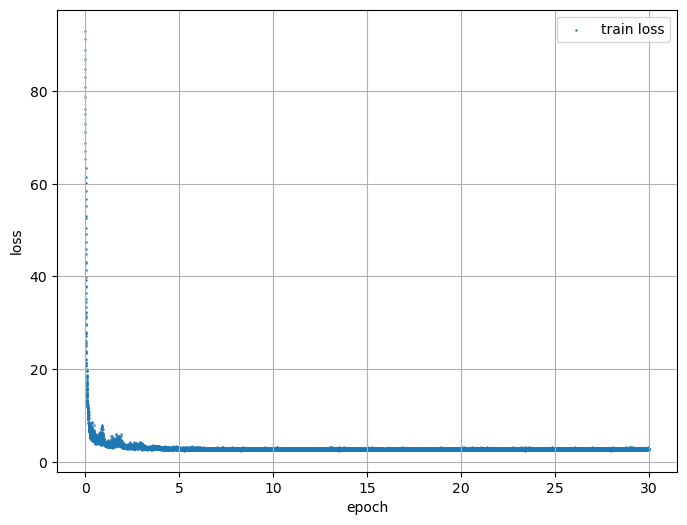

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(np.linspace(0, epochs, epochs*int(x_train.shape[0]/batch_size)), prob_normal_train_loss, label = "train loss", s = 0.5)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")

ax.legend()
ax.grid()

plt.show()

Using Pyro's ''predictive'' model we get predictions for the validation data from sampled parameters

In [11]:
total_samples = 100 # Number of model samples

observs = np.zeros((total_samples, x_test.shape[0]))
bar = trange(total_samples)
for ind_samp, num in zip(range(total_samples),bar):
    y_hat_test = np.zeros_like(y_test)
    predictive = Predictive(model, guide=mean_field_guide, num_samples=1)
    for batch_idx in range(int(x_test.shape[0] / batch_size)):
        batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
        X_batch_test= x_test[batch_low:batch_high]
        
        samples = predictive(X_batch_test)
        y_hat_test[batch_low:batch_high] = np.array(samples['obs'].detach().cpu())
        bar.set_postfix(eval_complete=f'{batch_idx/x_test.shape[0]*batch_size:.3f}')
    observs[ind_samp] = y_hat_test

  0%|          | 0/100 [00:00<?, ?it/s]

Counting the most probable class

In [12]:
yhats = np.array([np.bincount(np.array(el).astype(int)).argmax() for el in observs.transpose(1,0)])

Printing accuracy (averaged and between classes)

In [13]:
av_acc = MulticlassAccuracy(num_classes = labels_num, average='weighted')
print(f"Averaged accuracy: {av_acc(y_test, torch.tensor(yhats))}")

Averaged accuracy: 0.23589999973773956


In [14]:
class_acc = MulticlassAccuracy(num_classes = labels_num, average='none')
print(f"Class accuracy: {class_acc(y_test, torch.tensor(yhats))}")

Class accuracy: tensor([0.2685, 0.4089, 0.1439, 0.1303, 0.1319, 0.0866, 0.1397, 0.1693, 0.1311,
        0.1791])


Printing F1-score (for class)

In [15]:
class_acc = MulticlassF1Score(num_classes = labels_num, average='none')
print(f"Class F-1: {class_acc(y_test, torch.tensor(yhats))}")

Class F-1: tensor([0.3556, 0.5709, 0.1371, 0.1275, 0.1067, 0.0518, 0.1021, 0.1492, 0.1033,
        0.1200])


Plotting confusion matrix

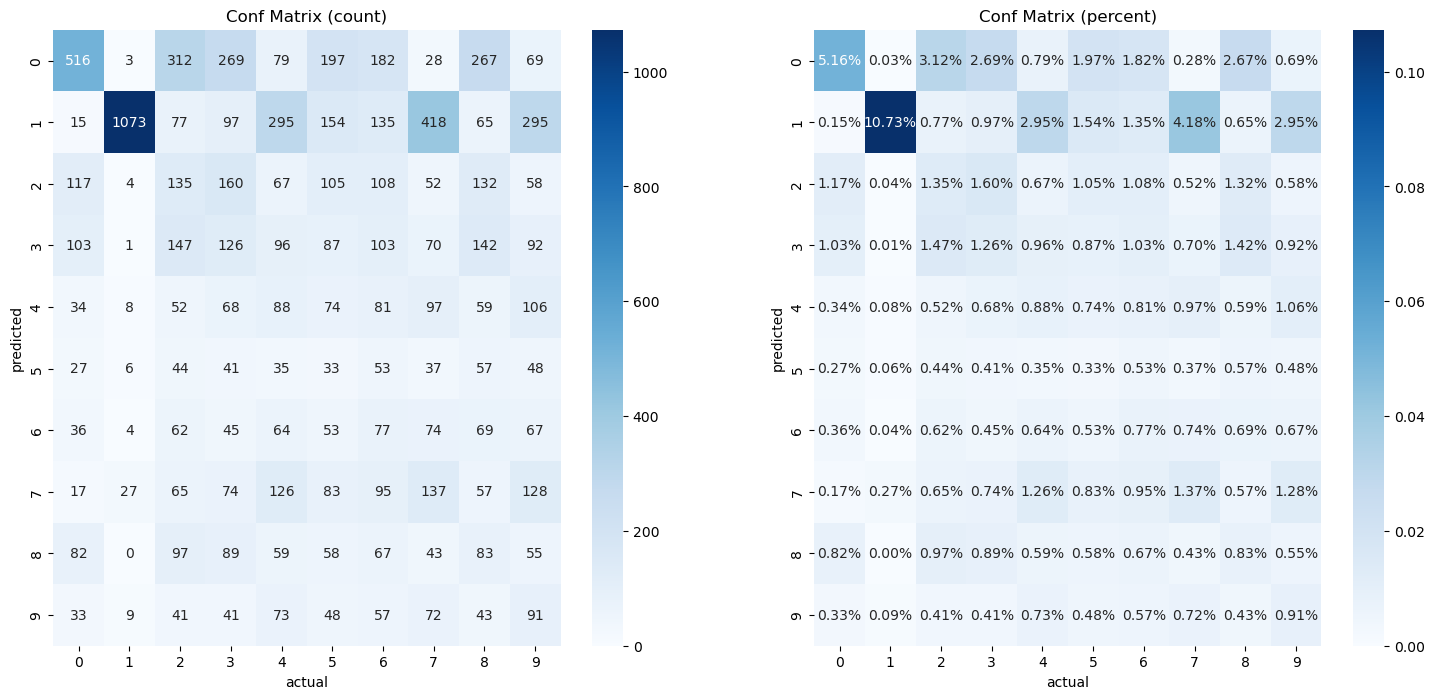

In [16]:
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=labels_num)
confmat = confmat(y_test, torch.tensor(yhats))

fig, ax = plt.subplots(1,2,figsize=(18,8))

sns.heatmap(confmat, annot=True, fmt = '0.0f',
            cmap='Blues', ax = ax[0])
sns.heatmap(confmat/torch.sum(confmat), annot=True, 
            fmt='.2%', cmap='Blues', ax = ax[1])
        
ax[0].set_xlabel('actual')
ax[0].set_ylabel('predicted')
ax[0].set_title('Conf Matrix (count)')
ax[1].set_xlabel('actual')
ax[1].set_ylabel('predicted')
ax[1].set_title('Conf Matrix (percent)')

plt.show()

### Robustness check

Let us constuct noised validation dataset and then check the model results on such a set

We will add additional gaussian noise to our data

In [17]:
x_test_noised = np.minimum(x_test + (torch.randn_like(x_test)*20 + 100), 255)

Display the noised number

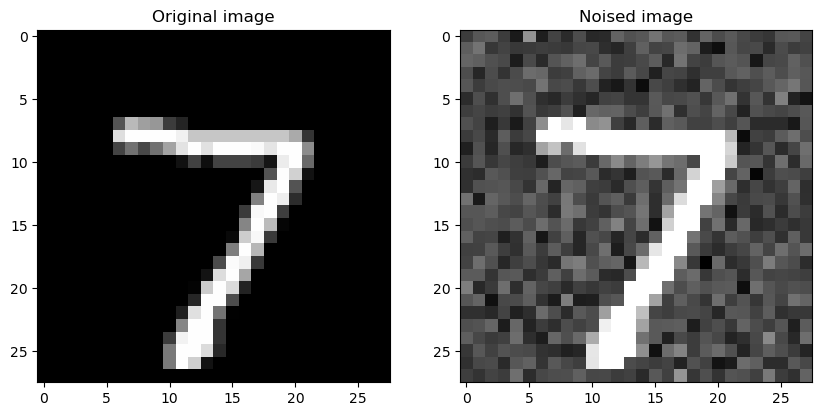

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,8))

ax[0].imshow(x_test[0].reshape(28,28), cmap='gray')
ax[1].imshow(x_test_noised[0].reshape(28,28), cmap='gray')

ax[0].set_title('Original image')
ax[1].set_title('Noised image')

plt.show()

Now let us use the previous methods to estimate the results of our model on noised validation set

  0%|          | 0/100 [00:00<?, ?it/s]

Averaged accuracy: 0.23879998922348022
Class accuracy: tensor([0.2273, 0.5418, 0.1343, 0.1317, 0.1230, 0.0974, 0.0996, 0.2105, 0.1390,
        0.1845])
Class F-1: tensor([0.3267, 0.6768, 0.1418, 0.1383, 0.0843, 0.0582, 0.0685, 0.1744, 0.1201,
        0.1184])


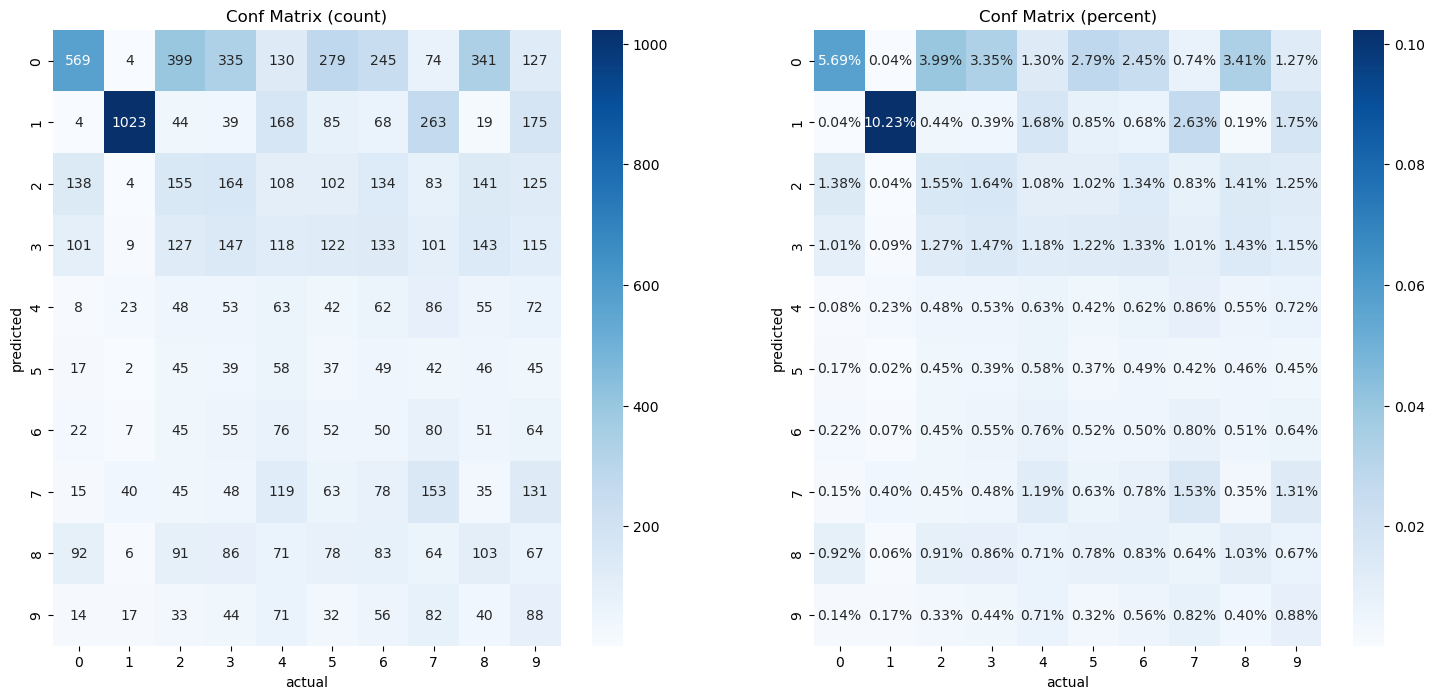

In [19]:
# Getting labels from noised data
total_samples = 100 # Number of model samples

observs_noised = np.zeros((total_samples, x_test_noised.shape[0]))
bar = trange(total_samples)
for ind_samp, num in zip(range(total_samples),bar):
    y_hat_test = np.zeros_like(y_test)
    predictive = Predictive(model, guide=mean_field_guide, num_samples=1)
    for batch_idx in range(int(x_test_noised.shape[0] / batch_size)):
        batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
        X_batch_test= x_test_noised[batch_low:batch_high]
        
        samples = predictive(X_batch_test)
        y_hat_test[batch_low:batch_high] = np.array(samples['obs'].detach().cpu())
        bar.set_postfix(eval_complete=f'{batch_idx/x_test_noised.shape[0]*batch_size:.3f}')
    observs_noised[ind_samp] = y_hat_test

yhats_noised = np.array([np.bincount(np.array(el).astype(int)).argmax() for el in observs_noised.transpose(1,0)])

# Computing accuracy and F-1 scores
av_acc = MulticlassAccuracy(num_classes = labels_num, average='weighted')
print(f"Averaged accuracy: {av_acc(y_test, torch.tensor(yhats_noised))}")
class_acc = MulticlassAccuracy(num_classes = labels_num, average='none')
print(f"Class accuracy: {class_acc(y_test, torch.tensor(yhats_noised))}")
class_acc = MulticlassF1Score(num_classes = labels_num, average='none')
print(f"Class F-1: {class_acc(y_test, torch.tensor(yhats_noised))}")

# Computing confusion matrix
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=labels_num).to('cpu')
confmat = confmat(y_test.clone().detach().to('cpu'), torch.tensor(yhats_noised).to('cpu'))

# Plotting confusion matrix
fig, ax = plt.subplots(1,2,figsize=(18,8))
sns.heatmap(confmat, annot=True, fmt = '0.0f',
            cmap='Blues', ax = ax[0])
sns.heatmap(confmat/torch.sum(confmat), annot=True, 
            fmt='.2%', cmap='Blues', ax = ax[1])
ax[0].set_xlabel('actual')
ax[0].set_ylabel('predicted')
ax[0].set_title('Conf Matrix (count)')
ax[1].set_xlabel('actual')
ax[1].set_ylabel('predicted')
ax[1].set_title('Conf Matrix (percent)')

plt.show()